In [5]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import string
from operator import itemgetter
import csv
from collections import Counter
import time
import random
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import matplotlib.pyplot as plt
import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
class LogisticRegression():
    def __init__(self, x) -> None:
        self.w = np.zeros(x.shape[1])

    def sigmoid(self, z):

        return 1 / (1 + np.exp(-z))

    def forward(self, x):
        coe = x @ self.w
        return self.sigmoid(coe)
    
    def loss(self, x, y):
        loss = -np.sum((y @ (np.log(self.forward(x))) + (1 - y) @ (np.log(1 - self.forward(x))))) / len(x)
        return loss
    
    def gradient_fun(self, x, y):
        h = self.forward(x)
        gra = -np.dot(x.T, (y - h))/len(x)
        return gra

def loadtext(filepath):
    with open(filepath, 'r') as f:
        txt = []
        for line in f.readlines():
            txt.append(line.strip().lower())
        
    return txt

def preprocessing(text, remove):
    #initial setting
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\s+', gaps = True)
    processed_txt = []

    for line in text:
        sentence = []
        #remove the punctuation
        table = str.maketrans(dict.fromkeys(string.punctuation))
        line = line.translate(table)

        line = re.sub(r'[^a-zA-Z\s]', u' ', line, flags = re.UNICODE)

        line_token = tokenizer.tokenize(line)

        #remove stop words
        if (remove == True):
            line_token = [w for w in line_token if not w in stop_words]
        

        for word in line_token:
            word = lemmatizer.lemmatize(word)
            word = stemmer.stem(word)
            sentence.append(word)

        processed_txt.append(sentence)
    
    return processed_txt

def inverted_index(pid_data, processed_data):

    dic = {}
    
    for i in range(len(pid_data)):
        processed_passage = processed_data[i]

        for token in processed_passage:
            token_num = processed_passage.count(token)

            if token not in dic.keys():
                dic[token] = {pid_data[i]: token_num}
            else:
                add_num = {pid_data[i]: token_num}
                dic[token].update(add_num)

    return dic


def generate_rel_dict(qid_list, pid_list, rel_list):
    '''
    generate two dict according to the given data
    '''

    rel_dict = {}
    non_rel_dict = {}

    for i in range(len(qid_list)):
        qid = qid_list[i]
        pid = pid_list[i]
        rel = rel_list[i]

        if rel > 0:
            add_dict = {pid:i}
            if qid in rel_dict.keys():
                rel_dict[qid].update(add_dict)
            else:
                rel_dict[qid] = add_dict
        else:
            add_dict = {pid:i}
            if qid in non_rel_dict.keys():
                non_rel_dict[qid].update(add_dict)
            else:
                non_rel_dict[qid] = add_dict

    return rel_dict, non_rel_dict

def generate_AP(model, rel_dic, non_rel_dic):
    
    total_ap = []
    qid_list = list(model.keys())

    for qid in qid_list:
        N = 0
        R_rel = 0
        precision = 0
        model_pid_list= list(model[qid].keys())
        rel_pid_list = list(rel_dic[qid].keys())
        

        if len(set(model_pid_list) & set(rel_pid_list)) == 0:
            precision = 0
            total_ap.append(precision)

        else:
            for pid in model_pid_list:
                N += 1
                if pid in rel_pid_list:
                    R_rel += 1
                    precision += R_rel/N
                else:
                    continue
                if R_rel == len(rel_dic[qid]):
                    break

        
            total_ap.append(precision / R_rel)
    
    return total_ap

def generate_NDCG(model, rel_dic, non_rel_dic):

    NDCG = []
    qid_list = list(model.keys())
    
    for qid in qid_list:
        N = 0
        N_opt = 0
        DCG = 0
        DCG_opt = 0
        model_pid_list = list(model[qid].keys())
        rel_pid_list = list(rel_dic[qid].keys())

        if len(set(model_pid_list) & set(rel_pid_list)) == 0:
            DCG += 0
        

        else:
            rel_qid_dic = rel_dic[qid]
            for pid in model_pid_list:
                N += 1
                if pid in rel_pid_list:
                    rel_pid = 1
                else:
                    rel_pid = 0
            
                DCG += (2**rel_pid - 1)/np.log(1 + N)

        #find the opt DCG
        rel_qid_dic = rel_dic[qid]
        best_sort_ranking = dict(sorted(rel_qid_dic.items(), key=itemgetter(1), reverse = True)[: 100])
        opt_pid_list = list(best_sort_ranking.keys())
        
        for pid in opt_pid_list:
            rel_pid = 1
            N_opt += 1
            DCG_opt += (2**rel_pid - 1)/np.log(1 + N_opt)

        NDCG.append(DCG / DCG_opt)
    

    return NDCG

In [7]:
train_data = pd.read_csv('train_data.tsv', sep = '\t', header = 0)
validation_data = pd.read_csv('validation_data.tsv', sep = '\t', header = 0)

train_qid_dict = np.load('train_qid_dict.npy', allow_pickle= True).tolist()
train_pid_dict = np.load('train_pid_dict.npy', allow_pickle= True).tolist()

train_qid_list = list(train_data['qid'])
train_pid_list = list(train_data['pid'])


train_rel_list = list(train_data['relevancy'])
train_rel_dic, train_non_rel_dic = generate_rel_dict(train_qid_list, train_pid_list, train_rel_list)

In [9]:
def get_row(dict):
    key_list = list(dict.keys())
    len_row = 0
    for key in key_list:
        len_row += len(dict[key])

    return len_row

print('the number of revelance rows is', get_row(train_rel_dic))#4797
print('the number of non-revelance rows is', get_row(train_non_rel_dic))#4359542

the number of revelance rows is 4797
the number of non-revelance rows is 4359542


In [10]:
def subsampling(pid_dict, non_rel_dic):
    
    qid_list = list(non_rel_dic.keys())


    save_index_list = []
    for qid in qid_list:

        non_rel_pid_dict = non_rel_dic[qid]

        non_rel_index_list = list(non_rel_pid_dict.values())
        save_len = int(len(non_rel_index_list) * 0.025)
        #shuffle the pid then delete by specific ratio
        random.shuffle(non_rel_index_list)
        new_non_rel_index_list = non_rel_index_list[0:save_len]

        #upadte the pid revelant
        save_index_list.extend(new_non_rel_index_list)

        #new_rel_dic[qid] = add_non_rel

    #new_pid_dict = {key:val for key, val in pid_dict.items() if key in save_pid_list}

    return save_index_list

new_non_index = subsampling(train_pid_dict, train_non_rel_dic)



rel_index = []
for qid in list(train_rel_dic.keys()):
    rel_index_list = list(train_rel_dic[qid].values())
    rel_index.extend(rel_index_list)

new_train_index = new_non_index + rel_index
print('current length of new dataset is', len(new_train_index))

new_train_data = []
for index in new_train_index:
    new_train_data.append(train_data[index:index + 1])

random.shuffle(new_train_data)

new_train_data = pd.concat(new_train_data, axis = 0, ignore_index=True)

print(new_train_data)

train_passage = preprocessing(new_train_data['passage'], True)
train_queries = preprocessing(new_train_data['queries'], True)


train_passage_dict = dict(zip(new_train_data['pid'], train_passage))
train_queries_dict = dict(zip(new_train_data['qid'], train_queries))

validation_passage_dict = np.load('validation_pid_dict.npy', allow_pickle= True).tolist()
validation_queries_dict = np.load('validation_qid_dict.npy', allow_pickle= True).tolist()

validation_passage = preprocessing(validation_data['passage'], True)
validation_queries = preprocessing(validation_data['queries'], True)

validation_qid_list = list(validation_data['qid'])
validation_pid_list = list(validation_data['pid'])

validation_rel_list = list(validation_data['relevancy'])
validation_rel_dic, validation_non_rel_dic = generate_rel_dict(validation_qid_list, validation_pid_list, validation_rel_list)

current length of new dataset is 109468
            qid      pid                                            queries  \
0       1085777  5399616                         what conglomeration means?   
1       1089036   756700                          vasospasms caused by what   
2       1102330   133273                 why do people grind teeth in sleep   
3       1083819  1557161                              what does finger mean   
4        414155   709410  is it normal to have heartburn during the firs...   
...         ...      ...                                                ...   
109463  1092482  7701954                 benefits of jackfruit for diabetes   
109464  1095787  4165191         how much is the card reader through paypal   
109465    56993  4290505                          building block definition   
109466  1086224  1412903              what causes boiling point to increase   
109467  1095747  5968505                           how much lactose in whey   

           

In [11]:
with open('validation_passage.txt', 'w') as f:
    for i in range(len(validation_passage)):
        f.write(' '.join(validation_passage[i]) + '\n')

sentences = LineSentence('validation_passage.txt')
model_validation_passage = Word2Vec(sentences, sg = 1, vector_size=100, window = 5, min_count=1, negative = 5, hs = 0, workers = 4)

In [12]:
with open('validation_queries.txt', 'w') as f:
    for i in range(len(validation_queries)):
        f.write(' '.join(validation_queries[i]) + '\n')

sentences = LineSentence('validation_queries.txt')
model_validation_queries = Word2Vec(sentences, sg = 1, vector_size=100, window = 5, min_count=1, negative = 5, hs = 0, workers = 4)

In [13]:
with open('train_passage.txt', 'w') as f:
    for i in range(len(train_passage)):
        f.write(' '.join(train_passage[i]) + '\n')

sentences = LineSentence('train_passage.txt')
model_train_passage = Word2Vec(sentences, sg = 1, vector_size=100, window = 5, min_count=1, negative = 5, hs = 0, workers = 4)

In [14]:
with open('train_queries.txt', 'w') as f:
    for i in range(len(train_queries)):
        f.write(' '.join(train_queries[i]) + '\n')

sentences = LineSentence('train_queries.txt')
model_train_queries = Word2Vec(sentences, sg = 1, vector_size=100, window = 5, min_count=1, negative = 5, hs = 0, workers = 4)

In [15]:
def average_embedding(data_dict, model):

    return_dic= {}
    for i in list(data_dict.keys()):
        data = data_dict[i]

        if len(data) != 0:
            token_vector = model.wv[data]
            avg_vector = np.mean(token_vector, axis = 0)

        add_dict = {i:avg_vector}
        return_dic.update(add_dict)

    return return_dic

def generate_data_for_models(data, embedding_query_dict, embedding_passgae_dict, rel_dict):

    qid_list = []
    pid_list = []
    queries_list = []
    passgaes_list = []
    rel_list = []
    for i in range(len(data)):
        qid = data.qid[i]
        pid = data.pid[i]

        if qid in embedding_query_dict.keys() and pid in embedding_passgae_dict.keys():
            qid_list.append(qid)
            pid_list.append(pid)
            queries_list.append(embedding_query_dict[qid].reshape(-1))
            passgaes_list.append(embedding_passgae_dict[pid].reshape(-1))

            if pid in rel_dict[qid].keys():
                rel = 1
            else:
                rel = 0
            rel_list.append(rel)
    
    query_data = np.array(queries_list)
    passages_data = np.array(passgaes_list)

    x_data = np.concatenate((query_data, passages_data), axis = 1)
    y_data = np.array(rel_list)
    
    return x_data, y_data

In [16]:
train_queries_embedding = average_embedding(train_queries_dict, model_train_queries)
train_passages_embedding = average_embedding(train_passage_dict, model_train_passage)

train_x_data, train_y_data = generate_data_for_models(new_train_data, train_queries_embedding, train_passages_embedding, train_rel_dic)

print("The size of x for training dataset is", train_x_data.shape)
print("The size of y for training dataset is", train_y_data.shape)


validation_queries_embedding = average_embedding(validation_queries_dict, model_validation_queries)
validation_passages_embedding = average_embedding(validation_passage_dict, model_validation_passage)

validation_x_data, validation_y_data = generate_data_for_models(validation_data, validation_queries_embedding, validation_passages_embedding, validation_rel_dic)

print("The size of x for validation dataset is", validation_x_data.shape)
print("The size of y for validation dataset is", validation_y_data.shape)

The size of x for training dataset is (109468, 200)
The size of y for training dataset is (109468,)
The size of x for validation dataset is (1103039, 200)
The size of y for validation dataset is (1103039,)


In [17]:
print("The size of x for training dataset is", train_x_data.shape)
print("The size of y for training dataset is", train_y_data.shape)


The size of x for training dataset is (109468, 200)
The size of y for training dataset is (109468,)


In [18]:
def train(x, y, epochs = 3000, step_size = 10, tol = 0.001, lr = 0.001): 
        add_b = np.ones((x.shape[0], 1))
        x = np.concatenate((add_b, x), axis = 1)
        model = LogisticRegression(x)
        step = 0
        loss_list = []
        for epoch in range(epochs):
            loss = model.loss(x, y)
            grad = model.gradient_fun(x[step:step + step_size], y[step:step + step_size])
            model.w -= lr * grad
            if step >= len(x):
                print('already more than length of data')
                break
            loss_list.append(loss)

            if np.linalg.norm(grad) < tol:
                print('grad already converges')
                break
            #if epoch % 300 == 0:
                #print('number of epochs: ' + str(epoch) + ' training loss :' + str(loss))
            
            step += step_size
        
        return model.w, loss_list


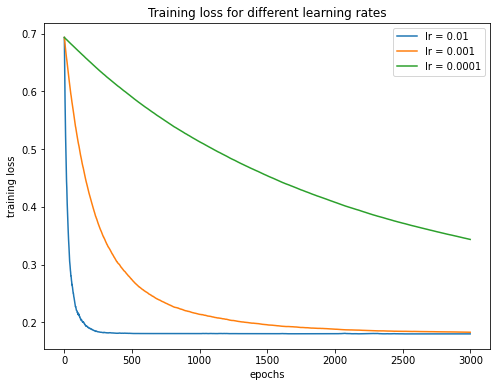

In [19]:
lr_list = [0.01, 0.001, 0.0001]
loss_list = []
plt.figure(figsize=(8, 6))
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss for different learning rates')
for i in range(len(lr_list)):
  w_lr, Loss_lr = train(train_x_data, train_y_data, lr = lr_list[i])
  loss_list.append(Loss_lr)
  plt.plot(np.arange(len(loss_list[i])), loss_list[i], label = 'lr = ' + str(lr_list[i]))
plt.legend()


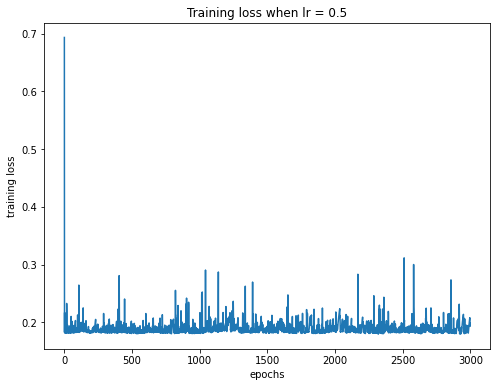

In [20]:
plt.figure(figsize=(8, 6))
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss when lr = 0.5')
w_lr, Loss_lr = train(train_x_data, train_y_data, lr = 0.5)
plt.plot(np.arange(len(Loss_lr)), Loss_lr, label = 'lr = 0.5')

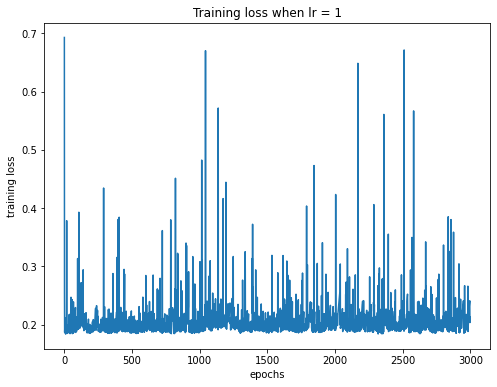

In [21]:
plt.figure(figsize=(8, 6))
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss when lr = 1')
w_lr, Loss_lr = train(train_x_data, train_y_data, lr = 1)
plt.plot(np.arange(len(Loss_lr)), Loss_lr, label = 'lr = 1')

In [22]:
w_LR, loss_LR = train(train_x_data, train_y_data, step_size = 30, lr = 0.001)

In [23]:
def gengerate_LR_score(qid, queries_embedding, passages_embedding):
  
  qid_dict = {}
  qid_vector = queries_embedding[qid]
  pid_index = [i for i,x in enumerate(validation_qid_list) if x == qid ]
  for index in pid_index:
    pid = validation_pid_list[index]
    pid_vector = passages_embedding[pid]
    qid_pid_vector = np.hstack((1, qid_vector, pid_vector))
    qid_pid_vector = qid_pid_vector.reshape(1, -1)
    model = LogisticRegression(qid_pid_vector)
    model.w = w_LR
    score = model.forward(qid_pid_vector)
    add_dict = {pid:score}
    qid_dict.update(add_dict)

  sorted_top_100 = dict(sorted(qid_dict.items(), key=itemgetter(1), reverse = True)[: 100])

  return sorted_top_100

LR_dict = {}
for qid in validation_qid_list:
  if qid in LR_dict.keys():
    continue
  else:
    qid_score_dict = gengerate_LR_score(qid, validation_queries_embedding, validation_passages_embedding)
    add_dict = {qid: qid_score_dict}
    LR_dict.update(add_dict)


In [24]:
len(LR_dict)

1148

In [25]:
LR_AP_list = generate_AP(LR_dict, validation_rel_dic, validation_non_rel_dic)
LR_AP = np.mean(LR_AP_list)
LR_AP

0.009413809445751785

In [26]:
LR_NDCG_list = generate_NDCG(LR_dict, validation_rel_dic, validation_non_rel_dic)
LR_NDCG = np.mean(LR_NDCG_list)
LR_NDCG

0.028097291011050914

In [28]:
with open('LR.txt','w') as f:
    for i in range(len(LR_dict.keys())):
        qid = list(LR_dict.keys())[i]
        pids = list(LR_dict[qid].keys())
        #if not equals 100, delete it
        if len(pids) < 100:
          continue
        for j in range(100):
          pid = pids[j]
          # qid A2 pid rank score algoname
          f.writelines([str(qid), '  A2  ', str(pid),'  ', str(j+1),'  ',str(float(LR_dict[qid][pid])), '  LR', '\n'])
f.close()